In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score

# Clustering:
Clustering in simple words means clubbing together data of 'similar' features. It is a very useful technique in both supervised and unsupervised learning of data.

In this project, we are dealing with different kinds of data sets cosnisting of movies, ratings and tags.

In [54]:
df1= pd.read_csv("movies.csv")
df2=pd.read_csv("ratings.csv")
df3=pd.read_csv("tags.csv", encoding='utf-8')
df1.head(3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [10]:
df2.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [55]:
df3.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


#### Some descriptions:
We are going to use only genre, rating, tag for this analysis. Some data especially time stamp, userid etc. will not be very useful for this analysis though they can be useful depending upon our end goals. 

In [26]:
#I tried to merge the tow data sets being too simplistic and optimistic which lead me to a 'wrong zone' for such a long period time that I am recording this mistake so as not to make any such mistake in future.
dataf = pd.merge(df1, df2)
dataf.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


### Clustering approach:

The tricky part in this project is to combine two or more different data sources having different base as explained below, and come up with an intelligible analysis. 

Note that the data set of movies is movie based(since it is sequenced with movie id) whereas the ratings data set is user based. Our approach is to do clustering based on tag lines. We first compare ratings of similar taglines of a movie and then plot them against each other. On this two dimensional plot, we will do knn clustering.

To illustrate the approach we have randomly chosen chosen two tag lines 'funny' and 'will' from 'will ferrel'(It may include other words invloving 'will'. But for the time being, we will ignore such inaccuracies.)

In [71]:
# Function computing the tag rating:
def tags_ratings(df2, df3, tags, column_names):
    tag_ratings = pd.DataFrame()
    for tag in tags:        
        tag_movies = df3[df3['tag'].str.contains(tag) ]
        avg_tag_votes_per_user = df2[df2['movieId'].isin(tag_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        tag_ratings = pd.concat([tag_ratings, avg_tag_votes_per_user], axis=1)
        
    tag_ratings.columns = column_names
    return tag_ratings
# Compute the mena ratings of funny and Will's movies.
tag_ratings = tags_ratings(df2, df3, ['funny', 'will'], ['mean_funny_rating', 'mean_will_rating'])
tag_ratings.head()

,mean_funny_rating,mean_will_rating
1,4.00,3.0
2,3.83,5.0
4,2.50,1.0
5,4.00,5.0
6,2.00,2.0


In [76]:
#We will select the datset having specific tag lines and compute their ratings.
def tag_rating_dataset(tag_ratings, upper_limit_1, lower_limit_2):
    tagged_dataset =    tag_ratings[((tag_ratings['mean_funny_rating'] < upper_limit_1 - 0.1) & (tag_ratings['mean_will_rating'] > lower_limit_2)) | ((tag_ratings['mean_funny_rating'] < upper_limit_1) & (tag_ratings['mean_will_rating'] > lower_limit_2))]
    tagged_dataset = pd.concat([tagged_dataset[:500], tag_ratings[:1]])
    tagged_dataset = pd.DataFrame(tagged_dataset.to_records())
    return tagged_dataset
# Bias the dataset
tagged_dataset = tag_rating_dataset(tag_ratings, 4.1, 2.5)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(tagged_dataset))
tagged_dataset.head()

Number of records:  180


,index,mean_funny_rating,mean_will_rating
0,1,4.00,3.0
1,2,3.83,5.0
2,5,4.00,5.0
3,8,3.50,4.0
4,14,3.00,3.0


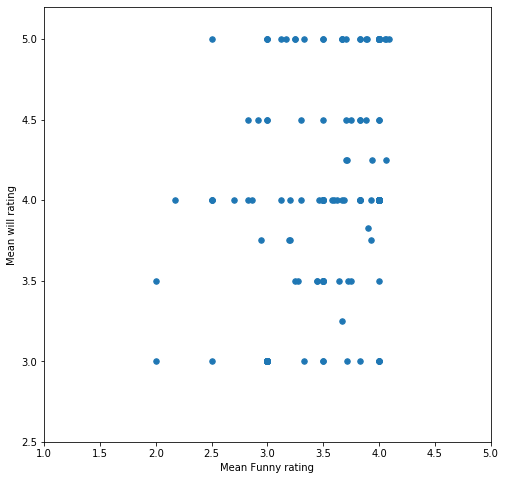

In [81]:
# Plotting scatterplots
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(1, 5)
    plt.ylim(2.5, 5.2)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
draw_scatterplot(tagged_dataset['mean_funny_rating'],'Mean Funny rating', tagged_dataset['mean_will_rating'], 'Mean will rating')

### Idea behind clustering:

Clustering is based on simple idea of computing the Eucleadian distance function and then partioning the data set in such a way that the sum of distances between the points within each partition is minimum. In our case, the dats is two dimensional, so it will minimise the distance over the plane to produce the clusters. 

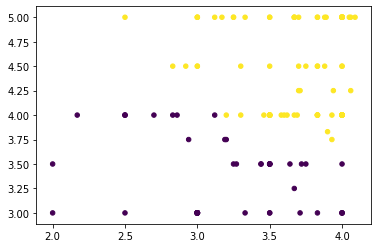

In [89]:
# Plotting the knn clusters having two clusters
import matplotlib
X = tagged_dataset[['mean_funny_rating', 'mean_will_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
kmeans_1 = KMeans(n_clusters=2)
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(tagged_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel("Mean funny rating")
    ax.set_ylabel("Mean Will rating")
clustered = pd.concat([tagged_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
plt.scatter(clustered['mean_funny_rating'],  clustered['mean_will_rating'] , c=clustered['group'], s=20, cmap=matplotlib.cm.get_cmap('viridis'))

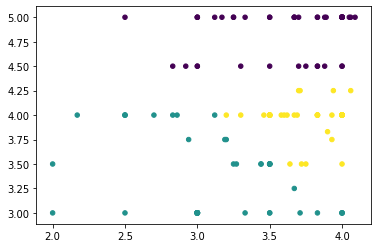

In [90]:
# Plotting the knn clusters having three clusters
import matplotlib
X = tagged_dataset[['mean_funny_rating', 'mean_will_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
kmeans_1 = KMeans(n_clusters=3)
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(tagged_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel("Mean funny rating")
    ax.set_ylabel("Mean Will rating")
clustered = pd.concat([tagged_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
plt.scatter(clustered['mean_funny_rating'],  clustered['mean_will_rating'] , c=clustered['group'], s=20, cmap=matplotlib.cm.get_cmap('viridis'))

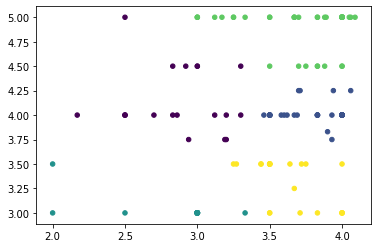

In [91]:
# Plotting the knn clusters having four clusters

import matplotlib
X = tagged_dataset[['mean_funny_rating', 'mean_will_rating']].values
# Import KMeans
from sklearn.cluster import KMeans
kmeans_1 = KMeans(n_clusters=5)
predictions = kmeans_1.fit_predict(X)
# Defining the cluster plotting function
def draw_clusters(tagged_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel("Mean funny rating")
    ax.set_ylabel("Mean Will rating")
clustered = pd.concat([tagged_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
plt.scatter(clustered['mean_funny_rating'],  clustered['mean_will_rating'] , c=clustered['group'], s=20, cmap=matplotlib.cm.get_cmap('viridis'))

/Users/bibek/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (71) found smaller than n_clusters (72). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/bibek/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (71) found smaller than n_clusters (77). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/bibek/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (71) found smaller than n_clusters (82). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/bibek/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (71) found smaller than n_clusters (87). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/bibek/anaconda3/lib/python3.7/site-packages/sklearn/clust

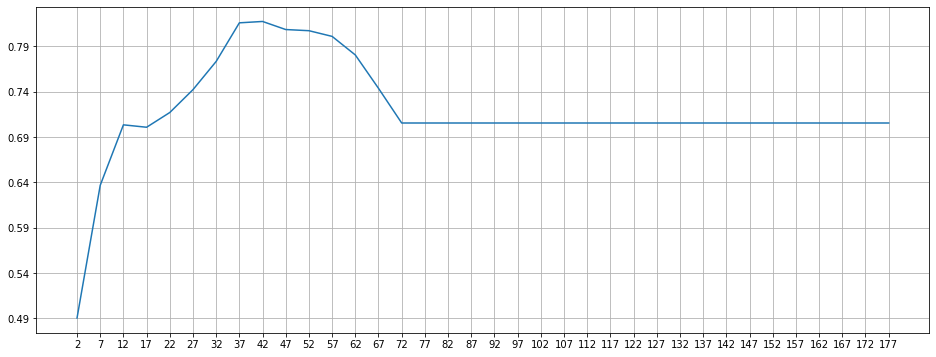

In [92]:
# Selecting our dataset to study
df = tagged_dataset[['mean_funny_rating','mean_will_rating']]
possible_k_values = range(2, len(X)+1, 5)
# Define function to calculate the clustering errors
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)
# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

### The error and the conclusion:
The error plot shows pretty high rate of error as k goes very high. That is primarily because of the repition in the data for given two tag lines we are considering. Since Will is a comedian(which incidentally I came to know much later), it is not also suprising that there is a coniderable overlap between funny tag and will tag. Cleaning our data would get us a better clustering for sure.

The approach can be explored in various other directions. One of them I was curious was to put more weight between genure and tag compared to rating(so that if two data points differ by genure, the disatnce will be penalised more). I am still figuring out the exact function for this.

Overall, clustering is an interesting approach with much flexibility to play within its domain.